## Data Analysis for epfml-higgs


In [1]:
import os 
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from toolz import partition_all

import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style("dark")
from IPython.display import HTML

In [2]:
DATA_PATH = '../data/'
TRAIN_PATH = os.path.join(DATA_PATH, 'train.csv')
TEST_PATH = os.path.join(DATA_PATH, 'test.csv')

In [3]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

### General Overview

In [4]:
print('Train shape: {} \nTest shape: {}'.format(train.shape, test.shape))

Train shape: (250000, 32) 
Test shape: (568238, 32)


In [5]:
HTML(train.head().to_html())

,Id,Prediction,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,100000,s,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,197.760,1.582,1.396,0.2,32.638,1.017,0.381,51.626,2.273,-2.414,16.824,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497
1,100001,b,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,125.157,0.879,1.414,-999.0,42.014,2.039,-3.011,36.918,0.501,0.103,44.704,-1.916,164.546,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226
2,100002,b,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,197.814,3.776,1.414,-999.0,32.154,-0.705,-2.093,121.409,-0.953,1.052,54.283,-2.186,260.414,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251
3,100003,b,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,75.968,2.354,-1.285,-999.0,22.647,-1.655,0.010,53.321,-0.522,-3.100,31.082,0.060,86.062,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000
4,100004,b,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,57.983,1.056,-1.385,-999.0,28.209,-2.197,-2.231,29.774,0.798,1.569,2.723,-0.871,53.131,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000


There are a lot of weird -999. 

Usually people fill with -999 missing values to train algorithms based on trees like random forest or extra trees because this is good to split the branches. 

However this approach is not good for linear models because it distorces the weights `{w_0, ..., w_d}`, the best alternative for linear models is use the `{mean, median}` instead. So one thing that we can try is remove -999, calculate the mean or median and then replace the -999 for each columns.

Any linear analysis will be messed up if the -999 are there.

In [6]:
print('Train and Test has the same columns? {}'.format(list(train.columns) == list(test.columns)))

Train and Test has the same columns? True


In [7]:
cols = list(train.columns)
cols

['Id',
 'Prediction',
 'DER_mass_MMC',
 'DER_mass_transverse_met_lep',
 'DER_mass_vis',
 'DER_pt_h',
 'DER_deltaeta_jet_jet',
 'DER_mass_jet_jet',
 'DER_prodeta_jet_jet',
 'DER_deltar_tau_lep',
 'DER_pt_tot',
 'DER_sum_pt',
 'DER_pt_ratio_lep_tau',
 'DER_met_phi_centrality',
 'DER_lep_eta_centrality',
 'PRI_tau_pt',
 'PRI_tau_eta',
 'PRI_tau_phi',
 'PRI_lep_pt',
 'PRI_lep_eta',
 'PRI_lep_phi',
 'PRI_met',
 'PRI_met_phi',
 'PRI_met_sumet',
 'PRI_jet_num',
 'PRI_jet_leading_pt',
 'PRI_jet_leading_eta',
 'PRI_jet_leading_phi',
 'PRI_jet_subleading_pt',
 'PRI_jet_subleading_eta',
 'PRI_jet_subleading_phi',
 'PRI_jet_all_pt']

In [8]:
features = list(set(cols) - set(['Id', 'Prediction']))

### Missing values in Features

In [9]:
columns_with_nans = list(filter(lambda c: pd.isnull(train[c]).sum(), features))
print('Columns with missing values: {cols}'.format(cols=columns_with_nans))

Columns with missing values: []


In [10]:
prop_minus999 = pd.DataFrame(dict(zip(features, 
                                      list(map(lambda c: 
                                               train[train[c]==-999].shape[0] / train.shape[0], 
                                               features)))),
                            index=['% prop_minus999']).T.apply(lambda x: round(x*100, 1))
print('Just columns contain -999 values')
HTML(prop_minus999[prop_minus999['% prop_minus999'] > 0].to_html())

Just columns contain -999 values


,% prop_minus999
DER_deltaeta_jet_jet,71.0
DER_lep_eta_centrality,71.0
DER_mass_MMC,15.2
DER_mass_jet_jet,71.0
DER_prodeta_jet_jet,71.0
PRI_jet_leading_eta,40.0
PRI_jet_leading_phi,40.0
PRI_jet_leading_pt,40.0
PRI_jet_subleading_eta,71.0
PRI_jet_subleading_phi,71.0


From the table above we can supose that -999 values don't happen randomly. 

Maybe all the columns with 71% level of -999 are mesuared by the same machine or something like that..

### Features types

In [11]:
unique_values = pd.DataFrame(dict(zip(features, list(map(lambda c: len(train[c].unique()), features)))), 
                             index=['n_unique']).T
unique_values['% prop_unique'] = (unique_values['n_unique'] / train.shape[0]).apply(lambda x: round(x*100, 2))
unique_values

,n_unique,% prop_unique
DER_deltaeta_jet_jet,7087,2.83
DER_deltar_tau_lep,4692,1.88
DER_lep_eta_centrality,1002,0.40
DER_mass_MMC,108338,43.34
DER_mass_jet_jet,68366,27.35
DER_mass_transverse_met_lep,101637,40.65
DER_mass_vis,100558,40.22
DER_met_phi_centrality,2829,1.13
DER_prodeta_jet_jet,16593,6.64
DER_pt_h,115563,46.23


Looking the table above and inspecting manually a little bit the columns, the only columns that should be considered as categorical is `PRI_jet_num`. To put this variable in the model there are some alternatives that can be tested together:
1. "Ignore" the fact that this is categorial and put just the number (this can mess with the linear parameter because the weights represents how much a change in the feature impact the output, but in this case doesn't make sense think like that because it is categorical)
2. Put as dummy variable
3. Count the number of observations for each category and replace the feature by it, so this is kinda a way to consider how much "rare" is the category - a lot of people use this in kaggle competitions

In [12]:
lookup_types = {'id': ['Id'],
                'y': ['Prediction'],
                'categorical': ['PRI_jet_num'] 
                'continuous': [
                    'DER_mass_transverse_met_lep',
                    'DER_mass_jet_jet',
                    'PRI_jet_subleading_eta',
                    'DER_pt_ratio_lep_tau',
                    'DER_deltaeta_jet_jet',
                    'PRI_met_phi',
                    'DER_prodeta_jet_jet',
                    'PRI_tau_eta',
                    'DER_deltar_tau_lep',
                    'PRI_jet_subleading_pt',
                    'DER_pt_tot',
                    'DER_met_phi_centrality',
                    'PRI_tau_pt',
                    'PRI_met_sumet',
                    'PRI_jet_leading_phi',
                    'DER_pt_h',
                    'DER_mass_MMC',
                    'DER_mass_vis',
                    'PRI_jet_all_pt',
                    'PRI_met',
                    'PRI_jet_leading_pt',
                    'PRI_jet_subleading_phi',
                    'DER_sum_pt',
                    'PRI_tau_phi',
                    'PRI_lep_phi',
                    'PRI_lep_eta',
                    'PRI_jet_leading_eta',
                    'PRI_lep_pt',
                    'DER_lep_eta_centrality'
          ]}

SyntaxError: invalid syntax (<ipython-input-12-3f602fe9dfc4>, line 4)

### Correlation Matrix - Features

***Spearman - rank correlation***

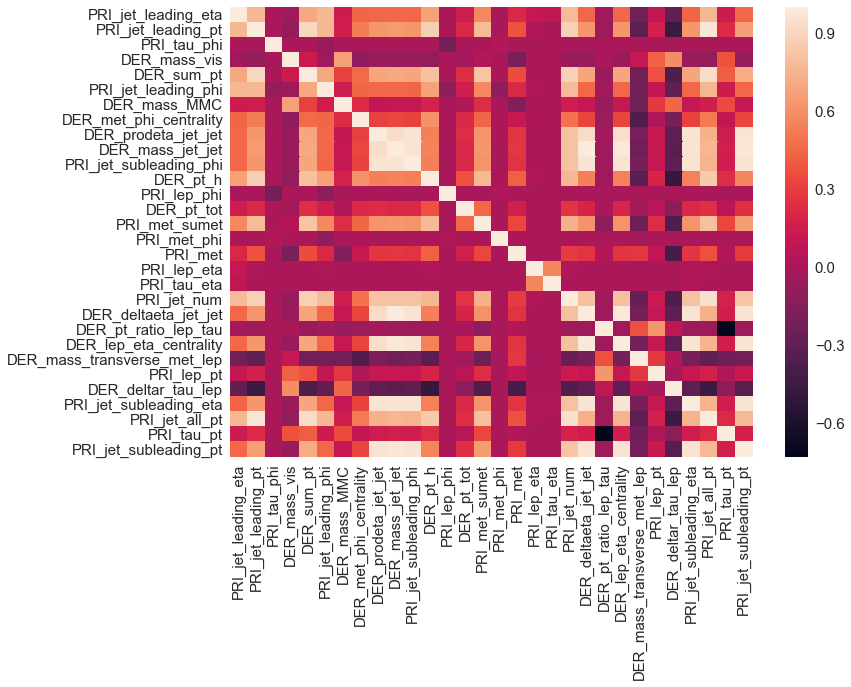

In [13]:
corr = train[features].corr(method='spearman')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, ax=ax);

The columns `PRI_` are high correlation among each other, so some of them can be dropped to avoid ill-conditioned.

### Relation Prediction VS Features
-999 dots will be removed

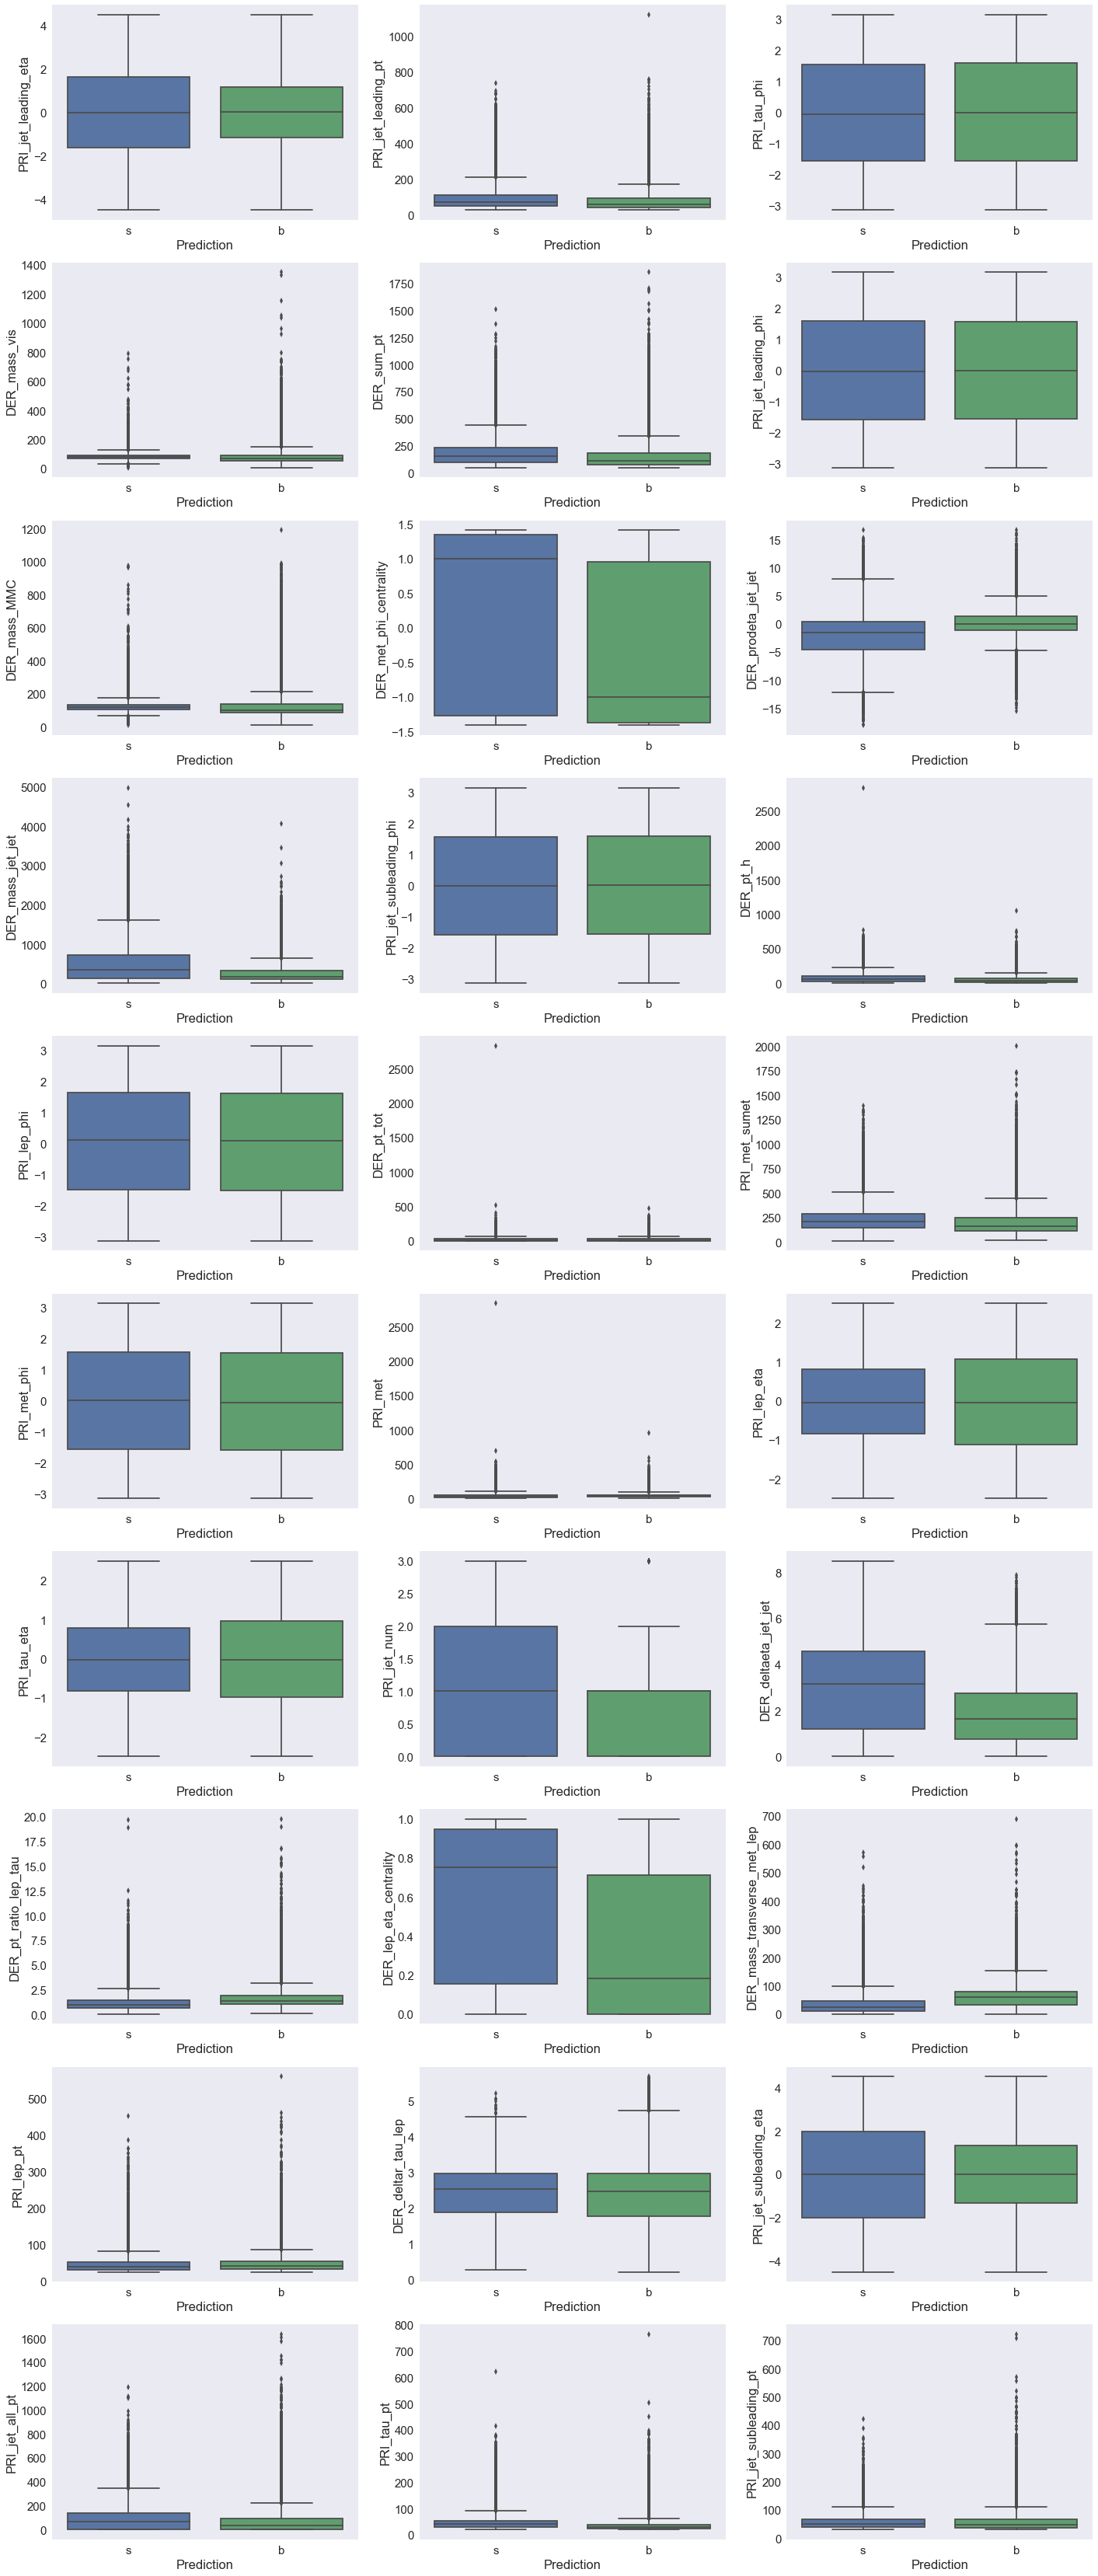

In [14]:
chart_cols = 3
chart_rows = int((len(features) - 1) / chart_cols + 1)
partitions = list(partition_all(chart_cols, features))

fig, axs = plt.subplots(ncols=chart_cols, nrows=chart_rows)
fig.set_size_inches(8 * chart_cols, 6 * chart_rows)
for i, set_features in enumerate(partitions):
    for j, feature in enumerate(set_features):
        pos = axs[i][j]
        sns.boxplot(x='Prediction', y=feature, data=train[train[feature]!=-999], ax=pos);

### "Predictive power" of Features

In [15]:
model = RandomForestClassifier(n_estimators=100)
y_binary = pd.DataFrame(train['Prediction'].apply(lambda x: 0 if x=='s' else 1))
model.fit(train[features], y_binary)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

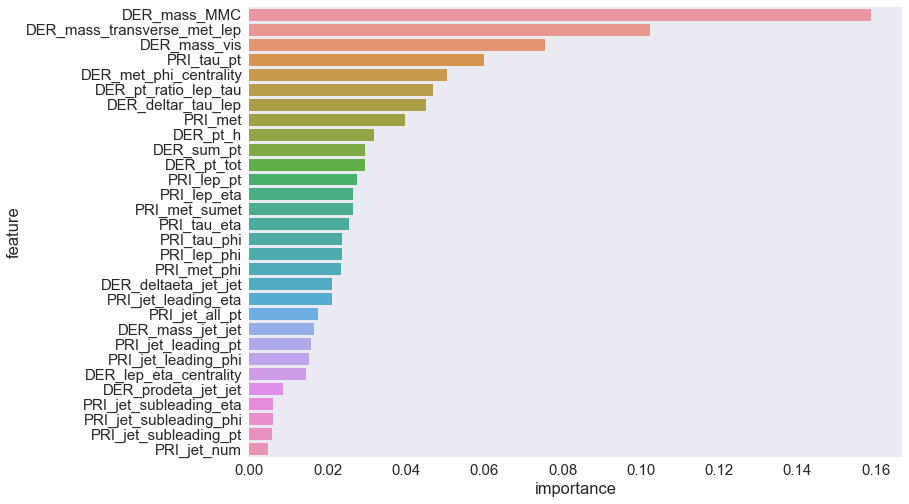

In [18]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
importances = pd.DataFrame(list(zip(features, model.feature_importances_)), 
                           columns=['feature', 'importance']).sort_values('importance', ascending=False)
sns.barplot(y='feature', x='importance', data=importances);